# Experiments with Bluetooth Low Energy Beacon Signals

## Imports

In [20]:
# Enable inline Matplotlib
%matplotlib inline

## Imports ##
# JSON
import json

# NumPy
import numpy as np

# Pandas
import pandas as pd
pd.plotting.register_matplotlib_converters()
pd.set_option('display.min_rows', 250)
pd.set_option('display.max_rows', 500)

# Matplotlib
import matplotlib.pyplot as plt

# SciPy
from scipy import stats

# scikit-learn
from sklearn.linear_model import LinearRegression

# seaborn
import seaborn as sns

## Constants and Helper Functions

In [21]:
# Constant that indicated how long each captured beacon be considered to be present (value in milliseconds).
# This effect can be simulated by a running average window over the collected data.
beacons_inactivity_timer=5000
# Constant that indicates how often the device reports about the surrounding beacons (value in milliseconds). 
# This effect can be simulated by resampling the collected data.  
beacons_refresh_interval=1000

# A function that receives the path to a JSON file containing a data collection run to load that file.
# It also receives a few extra to append to the loaded data which characterize the objective of the loaded data, i.e.:
# - The "target beacons" that we were interested in during the data collection phase.
# - The distance that those target beacons were from the data collection point.
def log_loader(file_path, target_beacons, distance):
    with open(file_path) as json_file:
        log = json.load(json_file)
        log['target_beacons'] = target_beacons
        log['distance'] = distance   
        return log

# This function receives a loaded of logs (see previous function), iterates over them, and unrolls them into a DataFrame.
def convert_logs_to_dataframe(logs):
    # List of per log intermediary DataFrames.
    dfs = []
    # Iterate over each log.
    for log in logs:
        # List of lists that represent a table that will be converted into a DataFrame.
        table = []
        # Iterate over the list of target beacons.
        for beacon in log['target_beacons']:
            # Iterate over the logging sessions contained within a log file.
            for entries in log['sessions'].values():
                # Iterate over the entries of each of those sessions.
                for entry in entries:
                    # Get each of the readings in the the entry.
                    reading = entry['reading']
                    # Check if the reading matches our target iBeacon.
                    if reading['type'] == 'iBeacon' and reading['values'][0] == beacon['uuid']\
                    and reading['values'][1] == beacon['major'] and reading['values'][2] == beacon['minor']:
                        # If so extract all the information into and append as row in the table
                        table.append([log['name'],
                                      pd.to_datetime(log['timestamp'], unit='ms'),
                                      entry['id'],
                                      reading['id'],
                                      reading['type'],
                                      str(reading['values']),
                                      reading['values'][0],
                                      reading['values'][1],
                                      reading['values'][2],
                                      reading['txPower'],
                                      reading['rssi'],
                                      pd.to_datetime(reading['timestamp'], unit='ms'),
                                      reading['avgRssi'],
                                      log['distance']])
        
        # After collection everything of interest in the log file into a plain "list of lists",
        # convert into a DataFrame by specifying the column names
        df = pd.DataFrame(table, columns=['filename',
                                          'creationTimestamp',
                                          'entry',
                                          'id',
                                          'type',
                                          'values',
                                          'uuid',
                                          'major',
                                          'minor',
                                          'txPower',
                                          'rssi',
                                          'timestamp',
                                          'avgRssi',
                                          'distance'])
        # If for some reason there are duplicate timestamps on a log file drop them.
        df.drop_duplicates(subset=['timestamp'], inplace=True)
        # Append the DataFrame to the list of DataFrames.
        dfs.append(df)
    # Return the single DataFrame that results from the concatenation of the individual DataFrames.
    # Also reset the index and select only the relevant columns.
    return pd.concat(dfs, ignore_index=True)[['timestamp','values', 'distance', 'rssi', 'avgRssi']]

# A function that should be applied per each device/distance combo, assuming that this corresponds to one and only one of
# the previously loaded log files.
def per_group(d):
    # Compute the overall RSSI mean and save it next to each sample
    d['rssi_mean'] = d['rssi'].mean()
    # Compute the overall RSSI standard deviation and save it next to each sample
    d['rssi_std'] = d['rssi'].std()
    # Compute the absolute standard score (z-score) for each RSSI sample
    d['rssi_zscore'] = np.abs(stats.zscore(d['rssi']))
    # Use the inverse of the zscore as the weight for each of the samples
    d['weight'] = 1 / d['rssi_zscore']
    # However, the z-score result can be 0 so 1/0 will result in infinity. We need to replace those values by something else.
    # For now, we simply indentify what is the largest value other than infinity and set all the instances of infinity by
    # a number that is slightly larger than that (1% to be exact).
    d.replace(np.inf, d.loc[d.weight != np.inf, 'weight'].max()*1.01, inplace=True)
    # Calculate a running average over the RSSI values to filter out undesired signal strength fluctuation. 
    # In practive, this type of filtering needs to reach a trade-off between stopping abrupt signal changes and 
    # responsiveness to user moveiment.
    d['rolling_mean_rssi'] = d[['timestamp', 'rssi']].rolling(pd.Timedelta(beacons_inactivity_timer, unit='ms'), on='timestamp')['rssi'].mean()
    # Return the DataFrame slice to be merged with all the others.
    return d

def resample_group(d, sample_interval=beacons_refresh_interval):
    r = d.set_index('timestamp', verify_integrity=True).resample(pd.Timedelta(sample_interval, unit='ms'), label='right', closed='right').pad()
    r['timestamp_diff'] = r.index
    r['timestamp_diff'] = r['timestamp_diff'].diff()
    return r

## Load Data

In [22]:
# Load Data
# Generate the list of distances at which we collected samples (i.e., 0 to 10 meters in 0.5 meters intervals)
distances = np.linspace(0,10,21)
# A dictionary that describes our data collection task.
collections = {
    # A laptop
    'laptop': {
        # collected samples at theses distances
        'distances': distances,
        # from the following targets:
        'targets': [{ 'uuid': '113069EC-6E64-4BD3-6810-DE01B36E8A3E', 'major': 1, 'minor': 102 }]
    },
    # A smartphone
    'smartphone':  {
        # collected samples at these distances
        'distances': distances,
        # from the following targets:
        'targets': [{ 'uuid': '113069EC-6E64-4BD3-6810-DE01B36E8A3E', 'major': 1, 'minor': 101 }]
    }
}

# Initialize a dictionary that will store the dataframes for each of the devices, indexed by the device name.
tables = {}
# Iterate over the data collection task defined above
for name, device in collections.items():
    # Initialize a list to collect the logs for each of the distances.
    logs = []
    # Iterate over each of the distances collected for the device.
    for d in device['distances']:
        # Load the corresponding file based on the following pattern
        logs.append(log_loader('data/beacons/'+name+'/beacons-'+str(d)+'.json', device['targets'], d))
    # Conver the list of logs to a DataFrame and story in the tables dictionary indexed by the device name.
    tables[name] = convert_logs_to_dataframe(logs)
    # Add a column to the DataFrame which identifies each of each lines as belonging to a certain device.
    tables[name]['device'] = name

# Concatenate the DataFrames for each device into a single DataFrame (recreate the index while at it).
data = pd.concat(tables.values(), ignore_index=True)
# Group the data by Device and Distance, apply the "per_collector_device_distance" function.
# NOTE: This is needed to perform a few extra computations for each of the logging sessions. I could have probably done this
# while loading the data but I decided to keep things separate. However, this may need to be changed if in the future
# grouping turns out not to be enough to slice the data on "per log" basis.
data = data.groupby(['device','distance']).apply(per_group).reset_index(drop=True)

# Save the DataFrame to a CSV file.
data.to_csv('out/beacons.csv')
# Save the DataFrame to an Excel file
data.to_excel('out/beacons.xlsx')
# Display the DataFrame
data

,timestamp,values,distance,rssi,avgRssi,device,rssi_mean,rssi_std,rssi_zscore,weight,rolling_mean_rssi
0,2019-10-03 12:57:22.098,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-56,-56.000000,laptop,-52.411765,2.530528,1.420967,0.703746,-56.000000
1,2019-10-03 12:57:22.230,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-50,-53.000000,laptop,-52.411765,2.530528,0.955076,1.047037,-53.000000
2,2019-10-03 12:57:22.515,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-52,-52.666667,laptop,-52.411765,2.530528,0.163062,6.132645,-52.666667
3,2019-10-03 12:57:22.922,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-49,-51.750000,laptop,-52.411765,2.530528,1.351083,0.740147,-51.750000
4,2019-10-03 12:57:23.059,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-53,-52.000000,laptop,-52.411765,2.530528,0.232945,4.292851,-52.000000
5,2019-10-03 12:57:23.199,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-53,-52.166667,laptop,-52.411765,2.530528,0.232945,4.292851,-52.166667
6,2019-10-03 12:57:23.331,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-49,-51.714286,laptop,-52.411765,2.530528,1.351083,0.740147,-51.714286
7,2019-10-03 12:57:23.460,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-53,-51.875000,laptop,-52.411765,2.530528,0.232945,4.292851,-51.875000
8,2019-10-03 12:57:23.593,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-54,-52.111111,laptop,-52.411765,2.530528,0.628953,1.589945,-52.111111
9,2019-10-03 12:57:23.721,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-55,-52.400000,laptop,-52.411765,2.530528,1.024960,0.975648,-52.400000


## Linear Regression

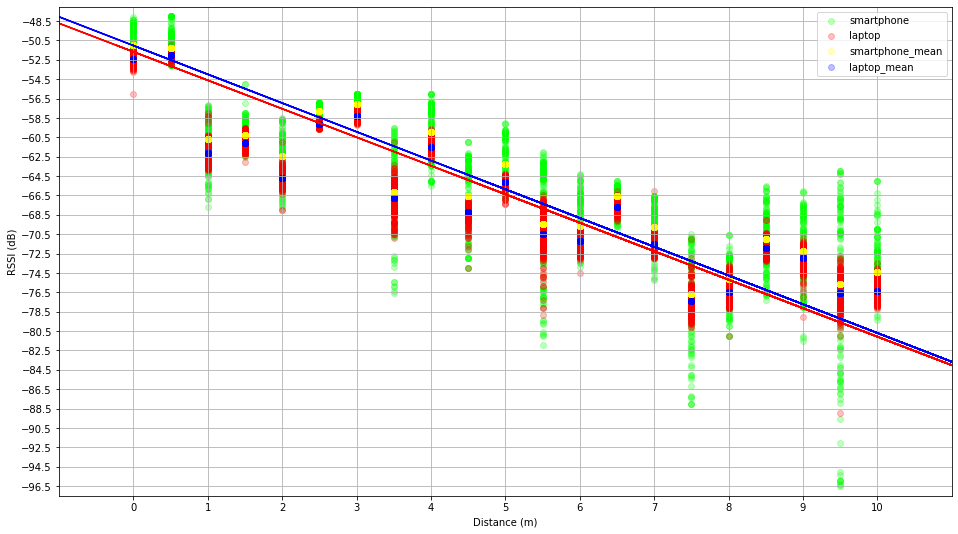

Linear Regression R2 Score 0.7647620889095519
Weighted Linear Regression R2 Score 0.8120973756239269
Linear Regreation: y = -0.3400493207318704x + -17.569440270061797
Weighted Linear Regreation: y = -0.3370438487018744x + -17.197104866830795


In [23]:
data_plot = data#[data.rssi_zscore < 3]
data_plot_laptop = data_plot[data_plot.device == 'laptop']
data_plot_smartphone = data_plot[data_plot.device == 'smartphone']

plt.figure(figsize=(16,9))

plt.scatter(data_plot_smartphone.distance, data_plot_smartphone.rolling_mean_rssi,c='#00ff003f', label='smartphone')
plt.scatter(data_plot_laptop.distance, data_plot_laptop.rolling_mean_rssi, c='#ff00003f', label='laptop')

plt.scatter(data_plot_smartphone.distance, data_plot_smartphone.rssi_mean,c='#ffff003f', label='smartphone_mean')
plt.scatter(data_plot_laptop.distance, data_plot_laptop.rssi_mean,c='#0000ff3f', label='laptop_mean')

X = data_plot['rolling_mean_rssi'].values.reshape(-1,1)
y = data_plot['distance'].values.reshape(-1,1)

lreg = LinearRegression().fit(X, y)
pred = lreg.predict(X)
plt.plot(pred, X, color='red')

wlreg = LinearRegression().fit(X, y, data_plot['weight'])
wpred = wlreg.predict(X)
plt.plot(wpred, X, color='blue')

plt.xlim(min(y)-1, max(y)+1)
plt.ylim(min(X)-1, max(X)+1)
plt.xticks(np.arange(min(y), max(y)+1, 1.0))
plt.yticks(np.arange(min(X), max(X)+1, 2.0))
plt.grid(True)
plt.legend(loc='upper right');
plt.xlabel('Distance (m)')
plt.ylabel('RSSI (dB)')
plt.show()

lreg_r2 = lreg.score(X, y)
wlreg_r2 = wlreg.score(X, y, data_plot['weight'])
# R2 Score
print("Linear Regression R2 Score", lreg_r2)
print("Weighted Linear Regression R2 Score", wlreg_r2)

# Equations
print('Linear Regreation: y =',str(lreg.coef_[0][0])+'x +',lreg.intercept_[0])
print('Weighted Linear Regreation: y =',str(wlreg.coef_[0][0])+'x +',wlreg.intercept_[0])

### Preparing Data for Cross Validation

In [40]:
from sklearn.model_selection import StratifiedKFold

X = data['rolling_mean_rssi'].values.reshape(-1,1)
y = data['distance'].astype(str).values.reshape(-1,1)
skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)
print(skf)

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index.size, "TEST:", test_index.size)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)
TRAIN: 7312 TEST: 822
TRAIN: 7313 TEST: 821
TRAIN: 7314 TEST: 820
TRAIN: 7316 TEST: 818
TRAIN: 7318 TEST: 816
TRAIN: 7322 TEST: 812
TRAIN: 7326 TEST: 808
TRAIN: 7326 TEST: 808
TRAIN: 7328 TEST: 806
TRAIN: 7331 TEST: 803


## Raw Data Visualization

### "General" Boxplot

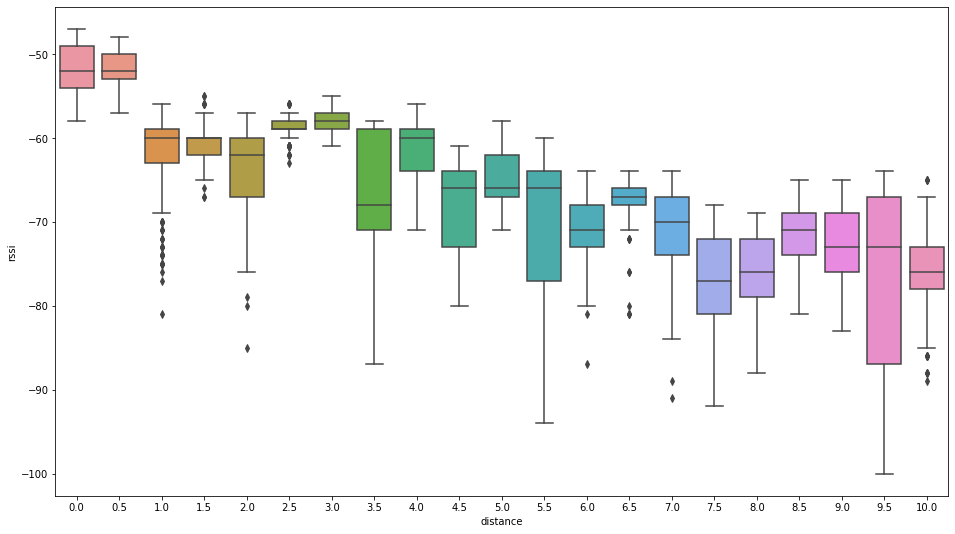

In [24]:
# Using Seaborn Boxplot to get an overview of the whole distance vs. rssi correlation.
# NOTE: I could have possibly made this with plain Matplotlib but Seaborn makes it prettier and easier.
fig = plt.figure(figsize=(16,9))
sns.boxplot(data['distance'], data['rssi'])
plt.show()

### RSSI over time per distance and device

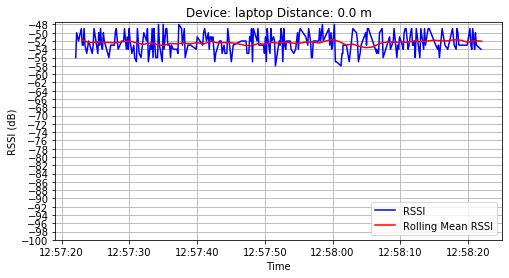

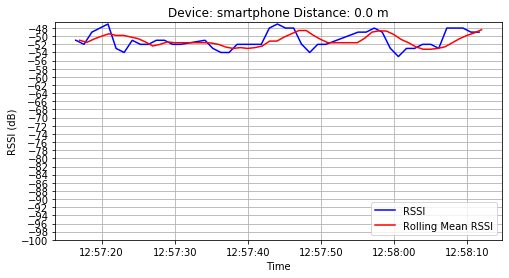

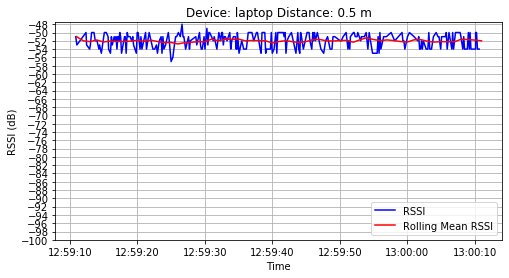

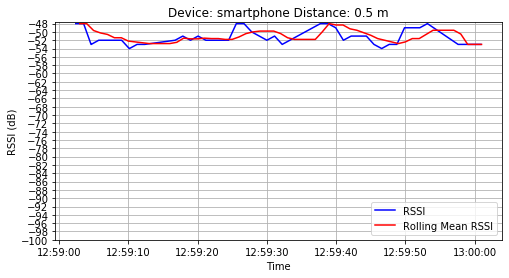

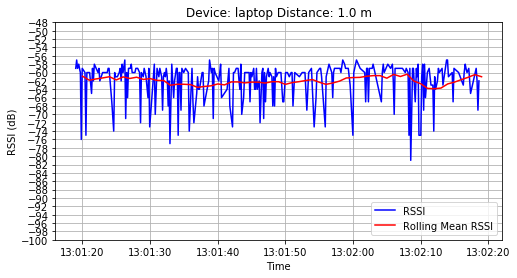

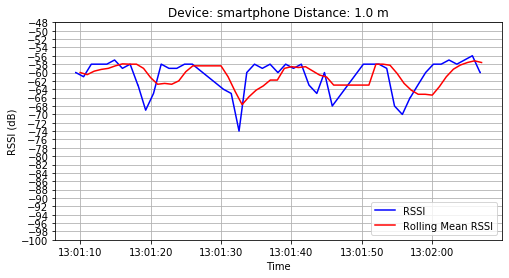

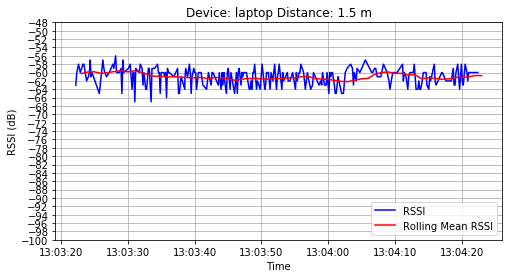

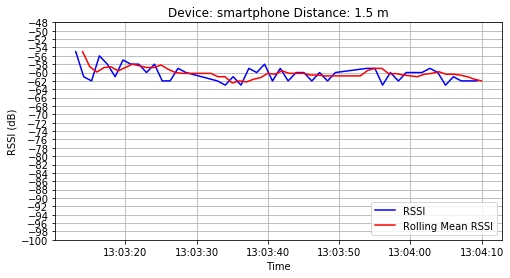

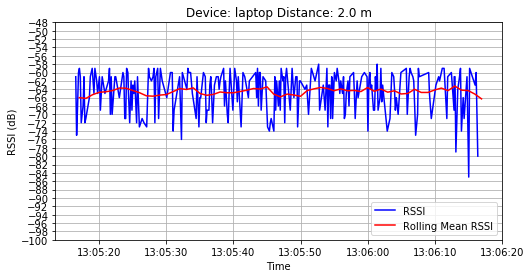

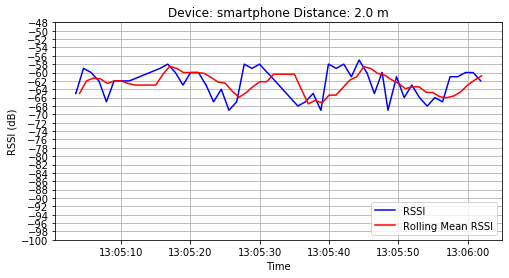

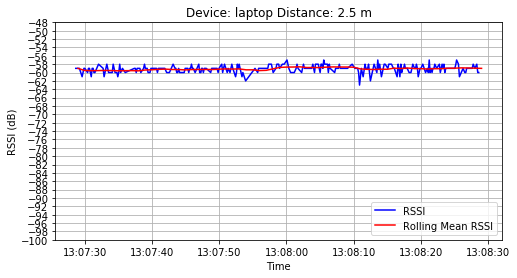

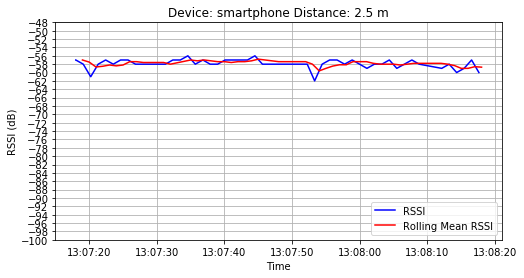

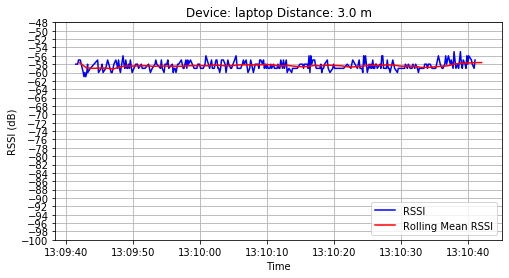

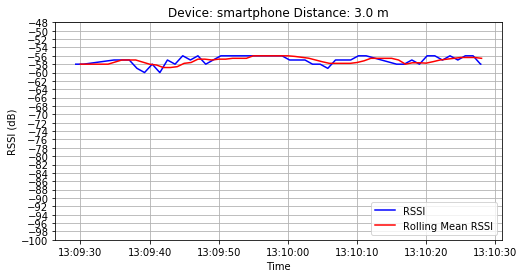

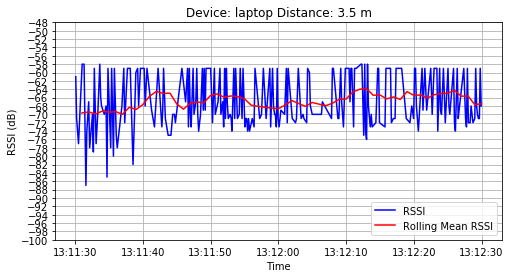

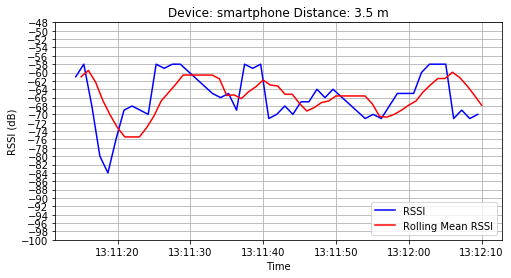

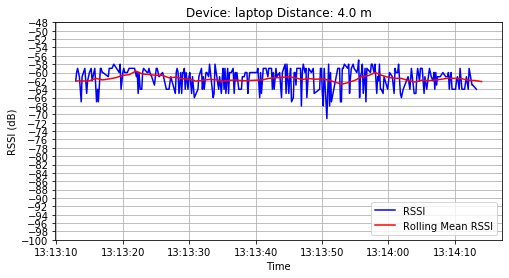

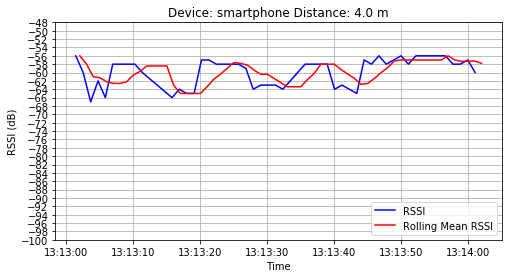

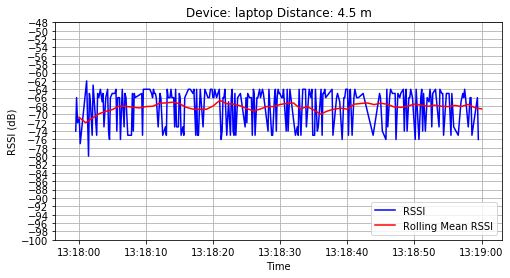

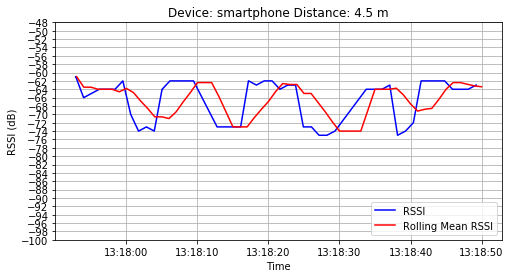

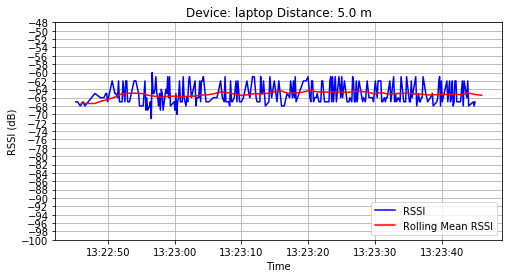

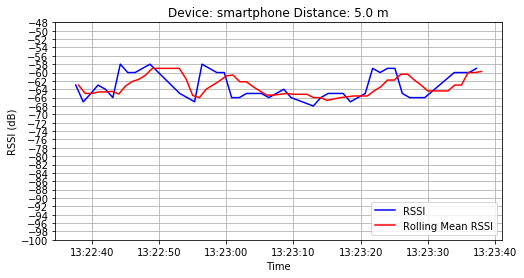

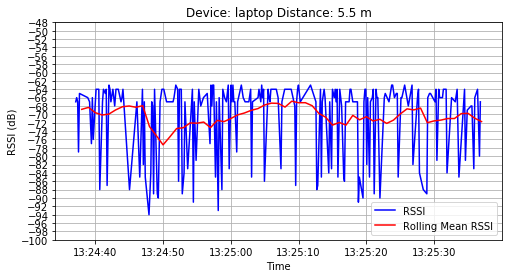

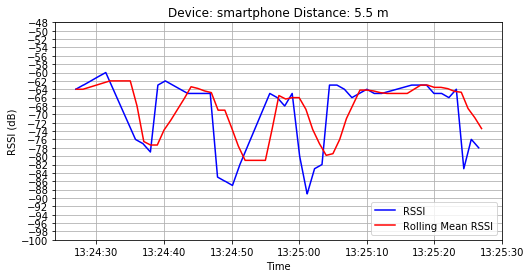

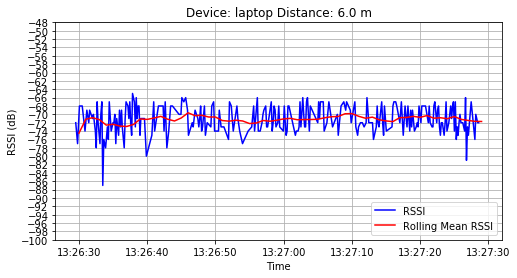

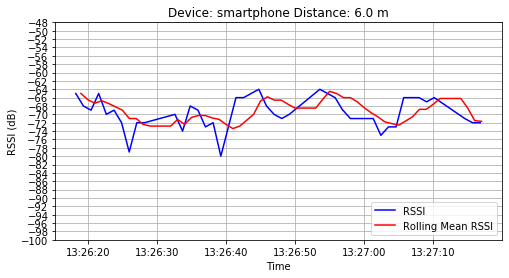

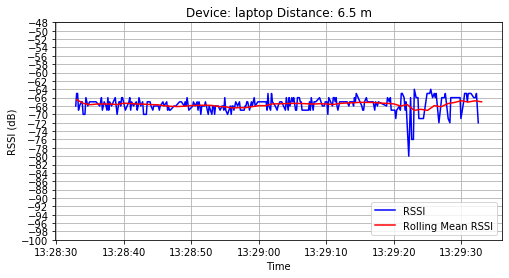

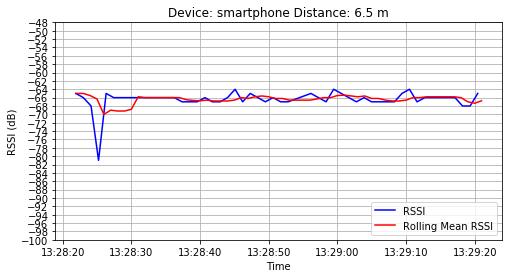

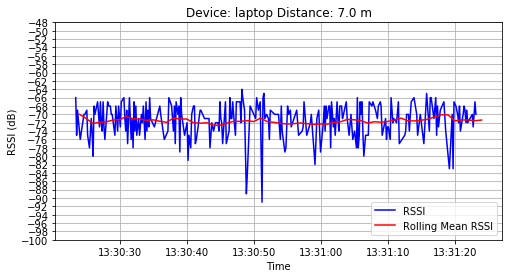

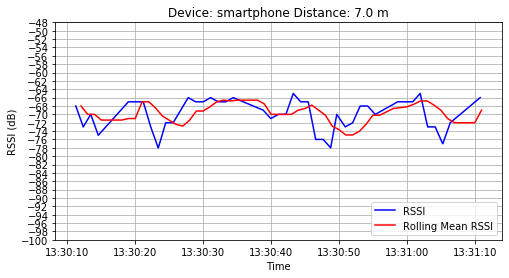

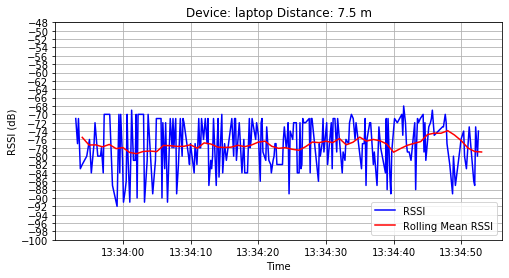

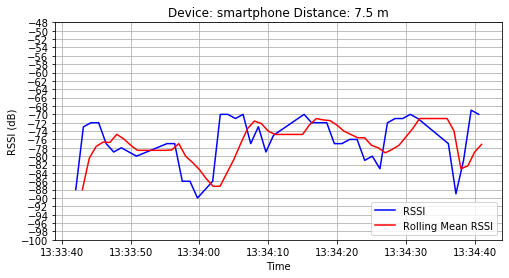

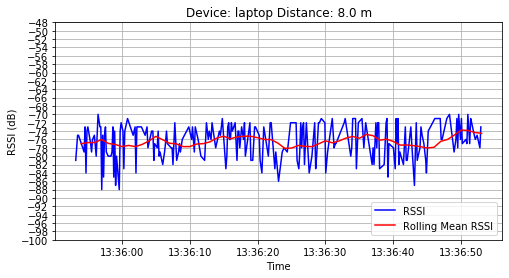

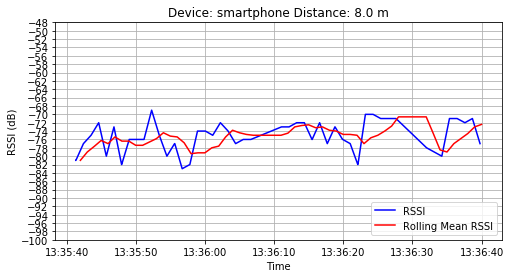

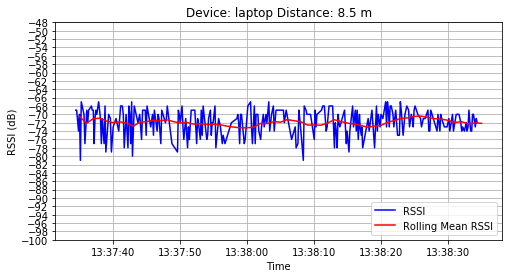

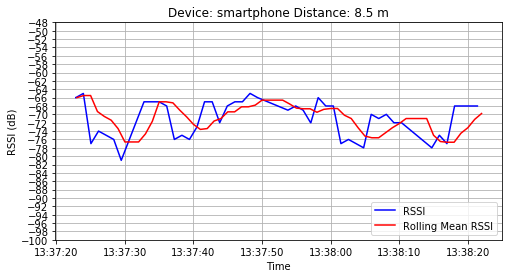

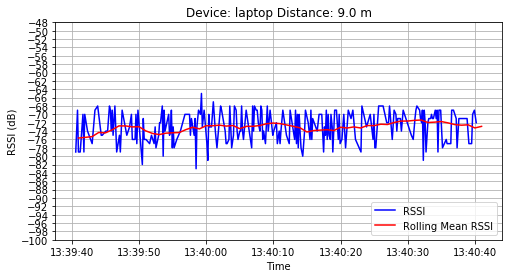

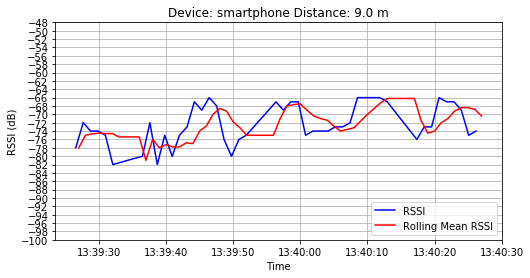

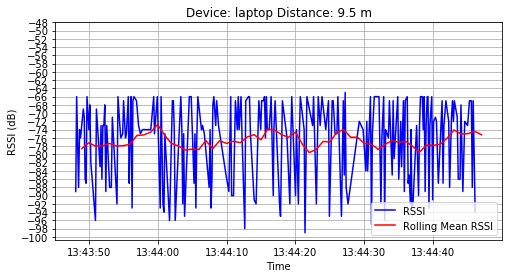

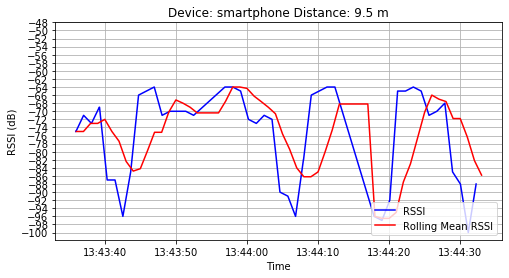

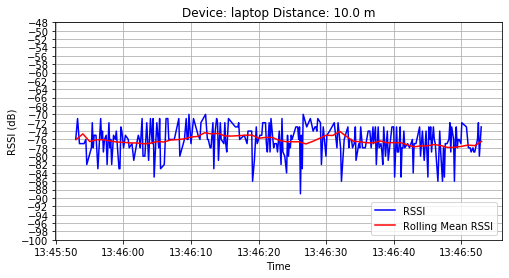

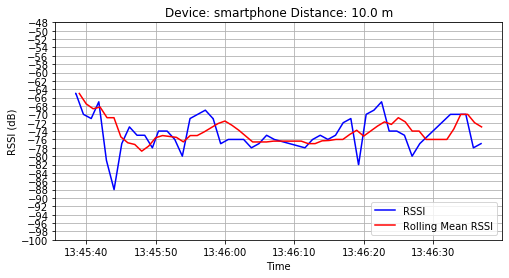

In [25]:
min_rssi = data['rssi'].min()
max_rssi = data['rssi'].max()

for k, d in data.groupby(['distance','device']):
    dr = resample_group(d, 1000)
    plt.figure(figsize=(8, 4))
    plt.title('Device: '+k[1]+' Distance: '+str(k[0])+' m')
    plt.xlabel('Time')
    plt.ylabel('RSSI (dB)')
    plt.plot(d['timestamp'], d['rssi'], label='RSSI', color='blue')
    plt.plot(dr.index, dr['rolling_mean_rssi'], label='Rolling Mean RSSI', color='red')
    plt.yticks(np.arange(min_rssi, max_rssi, 2.0))
    plt.legend(loc='lower right');
    plt.grid()
    plt.show()

### Resample Data

In [26]:
# Just resampling the data for future use (still nothing to do with it right now)
data_resample = data.groupby(['device','distance']).apply(resample_group).reset_index(drop=True)
# Display the result
data_resample

,values,distance,rssi,avgRssi,device,rssi_mean,rssi_std,rssi_zscore,weight,rolling_mean_rssi,timestamp_diff
0,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-49,-51.750000,laptop,-52.411765,2.530528,1.351083,0.740147,-51.750000,NaT
1,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-52,-52.363636,laptop,-52.411765,2.530528,0.163062,6.132645,-52.363636,00:00:01
2,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-49,-52.357143,laptop,-52.411765,2.530528,1.351083,0.740147,-52.357143,00:00:01
3,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-53,-52.250000,laptop,-52.411765,2.530528,0.232945,4.292851,-52.250000,00:00:01
4,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-56,-52.375000,laptop,-52.411765,2.530528,1.420967,0.703746,-52.375000,00:00:01
5,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-50,-52.434783,laptop,-52.411765,2.530528,0.955076,1.047037,-52.434783,00:00:01
6,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-52,-52.200000,laptop,-52.411765,2.530528,0.163062,6.132645,-52.200000,00:00:01
7,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-49,-52.000000,laptop,-52.411765,2.530528,1.351083,0.740147,-52.000000,00:00:01
8,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-56,-52.428571,laptop,-52.411765,2.530528,1.420967,0.703746,-52.428571,00:00:01
9,"['113069EC-6E64-4BD3-6810-DE01B36E8A3E', 1, 102]",0.0,-56,-52.809524,laptop,-52.411765,2.530528,1.420967,0.703746,-52.809524,00:00:01
